We are going to build an image classifier from scratch!

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob

In [2]:
data_dir = r'./dataset/dataset/' # Setting the dataset directory
classes = ['broadleaf', 'grass', 'soil', 'soybean'] # Setting all the available classes

num_file = 1100 # Number of files
all_files = []
num_data = num_file * len(classes)
Y = np.zeros(num_data) # Initialize all output values with 0

# Get the files to create labels, we encode the labels as
# broadleaf = 0
# grass = 1
# soil = 2
# soybean = 3
for i, cls in enumerate(classes):
    all_files += [f for f in glob.glob(data_dir + cls + '/*.tif')][:num_file]
    Y[i * num_file: (i + 1) * num_file] = i # Label all classes with int [0.. len(classes)]

In [3]:
image_width = 200
image_height = 200
image_channel = 3
dimension = image_width * image_height * image_channel

X = np.ndarray(shape=(num_data, image_width, image_height, image_channel), dtype=np.uint8) # Create a nd array

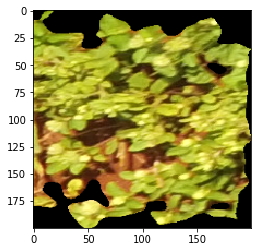

In [4]:
test = cv2.imread(all_files[0])
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
test = cv2.resize(test, (image_width, image_height)) 
plt.imshow(test)

In [5]:
for i, file in enumerate(all_files):
    img = cv2.imread(file)
    # cv2 reads images as BGR; so need to convert to RGB or colors will be inverted!
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X[i] = cv2.resize(img, (image_width, image_height)) # Add and load all images

In [6]:
# Split training, validation and testing set by creating empty arrays
X_train = np.empty(shape=(4000, image_width, image_height, image_channel), dtype=np.uint8)
X_val = np.empty(shape=(200, image_width, image_height, image_channel), dtype=np.uint8)
X_test = np.empty(shape=(200, image_width, image_height, image_channel), dtype=np.uint8)

Y_train = np.empty(4000)
Y_val = np.empty(200)
Y_test = np.empty(200)

# Set all x and y values
for i, cls in enumerate(classes):
    X_test[50 * i: 50 * (i + 1)] = X[np.where(Y == i)[0][:50]]
    X_val[50 * i: 50 * (i + 1)] = X[np.where(Y == i)[0][50:100]]
    X_train[1000 * i: 1000 * (i + 1)] = X[np.where(Y == i)[0][100:]]
    
    Y_test[50 * i: 50 * (i + 1)] = i
    Y_val[50 * i: 50 * (i + 1)] = i
    Y_train[1000 * i: 1000 * (i + 1)] = i

In [16]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'

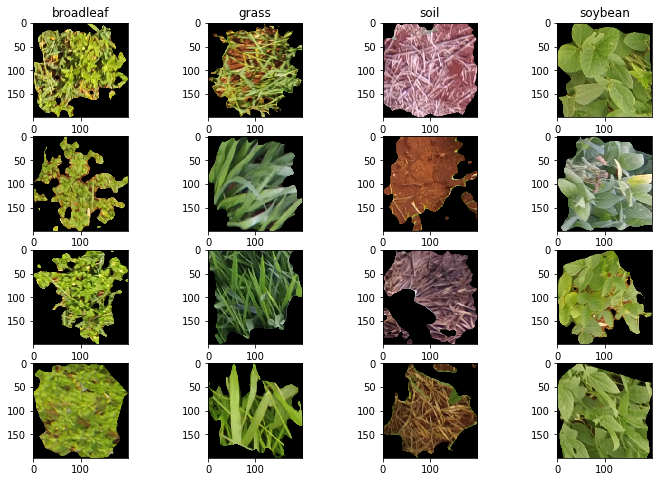

In [17]:
n_class = len(classes)
samples_per_class = 4

# Plot 4 images of each class
for Y, cls in enumerate(classes):
    indexes = np.flatnonzero(Y == Y_train)
    indexes = np.random.choice(indexes, samples_per_class, replace=False)
    for i, index, in enumerate(indexes):
        plt_index = i * n_class + Y + 1
        plt.subplot(samples_per_class, n_class, plt_index)
        plt.imshow(X_train[index].reshape(image_width, image_height, image_channel))
        if i == 0: plt.title(cls)

plt.show()

In [18]:
# Shuffle the images
train_indexes = np.random.permutation(X_train.shape[0]) # Create random indeces array with the length of X_train.shape[0]
Y_train = Y_train[train_indexes].astype(int) 
X_train = X_train[train_indexes]

In [22]:
# Reshape turn into datatype float64; right now it is still uint8
X_train = np.reshape(X_train, (X_train.shape[0], -1)).astype('float64')
X_test = np.reshape(X_test, (X_test.shape[0], -1)).astype('float64')
X_val = np.reshape(X_val, (X_val.shape[0], -1)).astype('float64')

In [23]:
# Normalize images
X_train = (X_train - 127.5)/127.5
X_test = (X_test - 127.5)/127.5
X_val = (X_val - 127.5)/127.5

In [58]:
class TwoLayerNet():
    def __init__(self, input_size, hidden_size, output_size, std= 1e-4):
        '''
        std: weight initialization term
        W1: first layer weight, shape(D x H) 
        W2: second layer weight shape(H x C) 
        C: num_classes(output_size) , H: hidden_size, D: data_dim(input_size) 
        '''
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def loss(self, X, y = None, reg=0.0):
        '''
        reg: regularization strength
        X: ndarray shape(N x C). N: num of data 
        y: vector of training label
        '''
        #DEfine relu activation function 
        relu = lambda x:np.maximum(0,x)

        #unpack
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        #Forward prop
        layer1 = relu(X.dot(W1) + b1)  #(N,D) x (D,H) = (N,H)
        scores = layer1.dot(W2) + b2

        #if target is not given then jump out 
        if(y is None): 
            return scores

        #compute the loss 
        ##Normalization trick to prevent overflow when compute exp 
        scores -= scores.max()#stack vertically

        scores = np.exp(scores)
        scores_sumexp = np.sum(scores, axis=1)#stack vertically

        ##Nomalize all score 
        softmax = scores / scores_sumexp.reshape(N,1)  #Shape: (N, C)
        #total loss of all training. -log of all correct score
        loss =  (-1.0) * np.sum(np.log(softmax[range(N),y]))

        ##Normalize the loss and add regularization strength 
        loss /= N 
        loss += reg * np.sum(W1 * W1) 
        loss += reg * np.sum(W2 * W2) 

        #Backward pass on the net 
        grads = {}

        correct_class_scores = scores[range(N), y]
        softmax[range(N), y] = (-1.0) * (scores_sumexp - correct_class_scores)/scores_sumexp
        softmax /= N


        #Want to find dW2(dL/dW2)
        # Derivation: dL/dW2 = dL/dscore * dscore/dW2(chain rule)
        #dL/dscore = softmax since L(score) = softmax(variable)
        #dscore/dW2 = relu_(hidden layer output)
        grads['W2'] = layer1.T.dot(softmax)
        grads['b2'] = np.sum(softmax, axis=0)#stack horizontally
        grads['W2'] += reg * 2 * W2

        #dL/dW1 = dL/dscore * dscore/drelu(layler1) * drelu(layer1)/dW1 
        #dL/dW1 = dW1 = softmax * W2 * X 
        hidden = softmax.dot(W2.T)

        #derivative of a max gate
        #Intuition: in forward pass if neuron didn't fire that mean. the derivative of that neuron 
        # is 0. This might be bad since this will kill gradient. 
        hidden[layer1 == 0] = 0 

        grads['W1'] = X.T.dot(hidden) 
        grads['b1'] = np.sum(hidden, axis=0) #stack horizontally 
        grads['W1'] += reg * 2 * W1

        return loss, grads

    def train(self, X, y, X_val, y_val, 
              learning_rate =1e-3, learning_rate_decay=0.95, 
              reg=5e-6, epochs=100, 
              batch_size=100, it_verbose = 1, verbose=False):
        '''
        Train using Gradient Descent 
        Input: 
            X: nd array shape(N x D) 
            y: vector of train label 
            X_val: nd array shape( n_VAL , D) Use as validation set after each epoch 
            y_val: vector of validation label 
        '''
        N, D = X.shape
        N_val = X_val.shape[0]
        iterations_per_epoch = max(int(np.floor(N/batch_size)), 1)
        
        loss_hist = []
        train_acc_hist = []
        val_acc_hist = []
        
        for it in range(epochs):
            available_indices = np.arange(N)
            for batch in range(iterations_per_epoch):
                sampling = np.random.choice(available_indices, batch_size, replace=False) 
                X_batch = X[sampling]
                y_batch = y[sampling]
            
                #compute loss and gradients
                loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
                loss_hist.append(loss) 
            
                #Update rule 
                self.params['W1'] += (-1.0) * learning_rate * grads['W1']
                self.params['b1'] += (-1.0) * learning_rate * grads['b1']
                self.params['W2'] += (-1.0) * learning_rate * grads['W2']
                self.params['b2'] += (-1.0) * learning_rate * grads['b2']
                
                # update list of images we have not used yet
                available_indices = np.delete(available_indices, sampling)
            
            if(verbose and it%it_verbose==0):
                print('Epoch: %d / %d | Loss: %f' % (it, epochs, loss)) 
            # Every epoch, check train and val accuracy and decay learning rate.
            if (it % iterations_per_epoch == 0):
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_hist.append(train_acc)
                val_acc_hist.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay
        return {
            'loss_hist':loss_hist,
            'train_acc_hist':train_acc_hist,
            'val_acc_hist':val_acc_hist
        }

    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
        classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
        the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
        to have class c, where 0 <= c < C.
        """
        y_pred = None
        relu = lambda x:np.maximum(0,x)
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        #Forward propagation though the network 
        layer1 = relu(X.dot(W1) + b1)
        scores = layer1.dot(W2) + b2 #shape: (N x C)
        y_pred = np.argmax(scores, axis=1)

        return y_pred

In [59]:
input_size = image_width * image_height * image_channel
hidden_size = 200
output_size = n_class 
std = 1e-3 # size initialization parameter

net = TwoLayerNet(input_size, hidden_size,output_size,std )

In [60]:
stats = net.train(X_train, Y_train, X_val, Y_val, 
              learning_rate =1e-5, learning_rate_decay=0.95, 
              reg=0.0, epochs=70, 
              batch_size=100, it_verbose = 10,verbose=True)

/anaconda3/envs/dummy_testing/lib/python3.7/site-packages/ipykernel_launcher.py:123: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Epoch: 0 / 70 | Loss: 1.386369
Epoch: 10 / 70 | Loss: 1.386066
Epoch: 20 / 70 | Loss: 1.386010
Epoch: 30 / 70 | Loss: 1.386142
Epoch: 40 / 70 | Loss: 1.385983
Epoch: 50 / 70 | Loss: 1.385996
Epoch: 60 / 70 | Loss: 1.385987


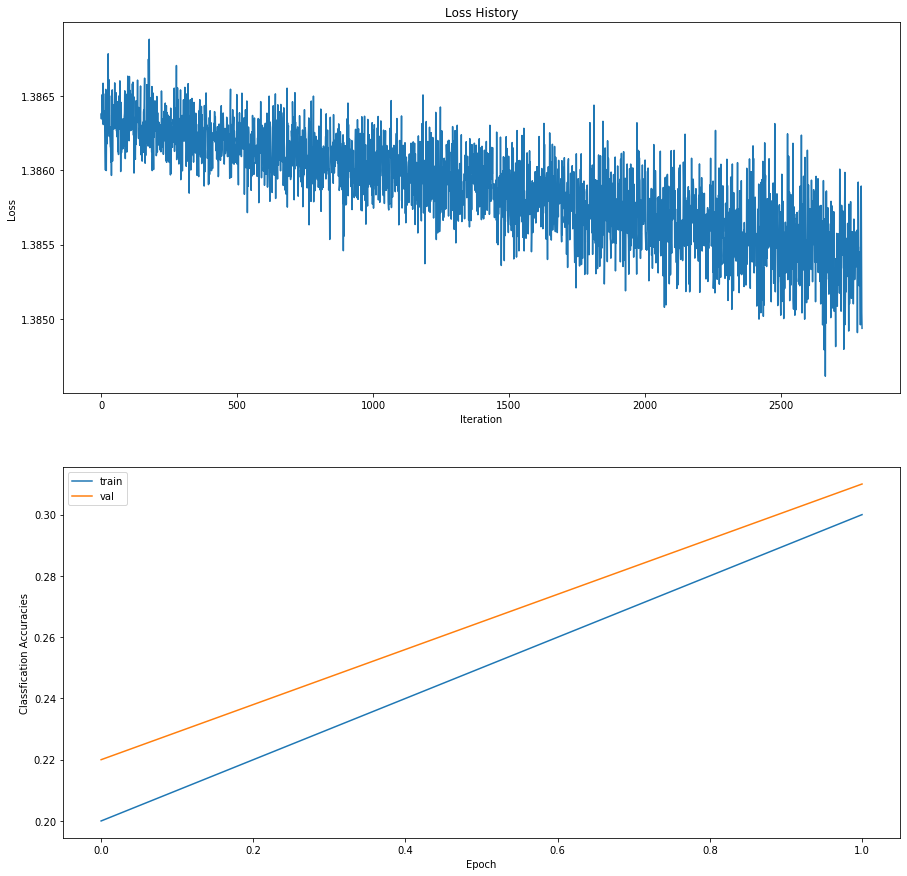

In [61]:
# plot loss history and train/ validation accuracies history
plt.rcParams['figure.figsize'] = (15.0, 15.0) # set default size of plots
plt.subplot(2,1,1) 
plt.plot(stats['loss_hist'])
plt.title('Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2,1,2)
plt.plot(stats['train_acc_hist'], label='train')
plt.plot(stats['val_acc_hist'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Classfication Accuracies')
plt.legend()
plt.show()

In [62]:
print((net.predict(X_test) == Y_test).mean())

0.41


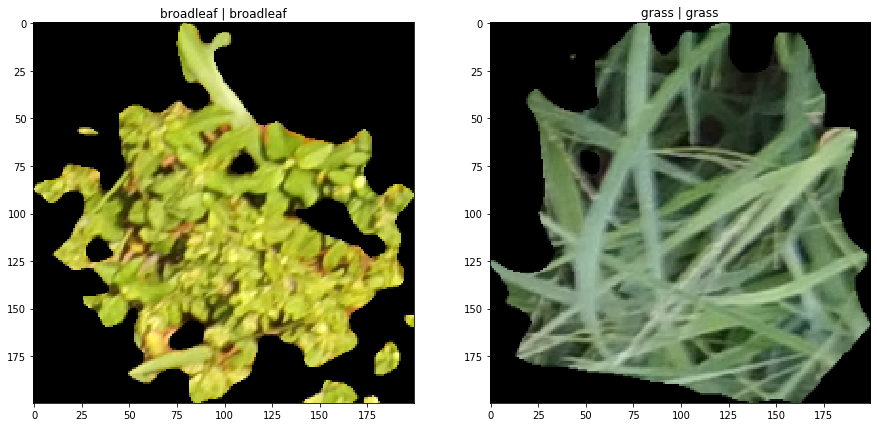

In [68]:
index = np.flatnonzero(0 == Y_train)
index = np.random.choice(index, 1, replace=False)
prediction = net.predict(X_train[index])

plt.subplot(1, 2, 1)
plt.title('{} | {}'.format(classes[0], classes[prediction[0]]))
img = 0.5*X_train[index].reshape(image_width, image_height, image_channel) +0.5
plt.imshow(img)

index = np.flatnonzero(1 == Y_train)
index = np.random.choice(index, 1, replace=False)
prediction = net.predict(X_train[index])

plt.subplot(1, 2, 2)
plt.title('{} | {}'.format(classes[1], classes[prediction[0]]))
img = 0.5*X_train[index].reshape(image_width, image_height, image_channel) +0.5
plt.imshow(img)